## Demostrator 0
#### Purpose:
- In this example we download ERA5 data on-demand for training the IceNet2 model within the Azure/Pangeo environment
- We also compare two methods (with/without Dask) to load the downloaded ERA5 data

#### Comments:
- We recommend to install the libraries into a virtual or conda environment
- For instance, the notebook only works if you have in before
    - Installed the Copernicus Climate Data Store cdsapi package
    - Registered and setup your CDS API key as described on [their website here](https://cds.climate.copernicus.eu/api-how-to)

#### Credits:
- Some code snippets were adapted from the IceNet2 repository authored by Tom Ardersson (BAS)

#### Author: 
Alejandro Coca-Castro (The Alan Turing Institute)

## Load libraries

In [1]:
import cdsapi
import xarray as xr
import numpy as np
import time
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

## Set distributed client

In [2]:
from dask.distributed import Client
client = Client()
client

/anaconda/envs/pangeo/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35357 instead
  expected, actual


Client Scheduler: tcp://127.0.0.1:37063 Dashboard: http://127.0.0.1:35357/status,Cluster Workers: 4 Cores: 4 Memory: 13.67 GiB


## Request ERA5 data from CDI API

In [3]:
cds = cdsapi.Client()

In [4]:
# Settings - as defined by TAndersson
## Variables
variables = {
    'tas': {
        'cdi_name': '2m_temperature',
    },
    'tos': {
        'cdi_name': 'sea_surface_temperature',
    },
    'ta500': {
        'plevel': '500',
        'cdi_name': 'temperature',
    },
}

## Target months, days and times
months = [
    '01', '02', '03', '04', '05', '06',
    '07', '08', '09', '10', '11', '12'
]

days = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12',
    '13', '14', '15',
    '16', '17', '18',
    '19', '20', '21',
    '22', '23', '24',
    '25', '26', '27',
    '28', '29', '30',
    '31',
]

times = [
    '00:00', '01:00', '02:00',
    '03:00', '04:00', '05:00',
    '06:00', '07:00', '08:00',
    '09:00', '10:00', '11:00',
    '12:00', '13:00', '14:00',
    '15:00', '16:00', '17:00',
    '18:00', '19:00', '20:00',
    '21:00', '22:00', '23:00',
]

In [5]:
# Variables - as defined by TAndersson
var = 'tas'
hemisphere = 'nh'
year = 2020

# Output folder and files
notebook_folder = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/ci-alejandroc-943cade0/code'

var_folder = os.path.join(notebook_folder,'data', hemisphere, var)
if not os.path.exists(var_folder):
    os.makedirs(var_folder)
    
download_path = os.path.join(var_folder, '{}_latlon_hourly_{}_{}.nc'.format(var, year, year))
daily_fpath = os.path.join(var_folder, '{}_latlon_{}_{}.nc'.format(var, year, year))

In [6]:
# Settings - as defined by TAndersson
## Hemisphere
if hemisphere == 'nh':
    area = [90, -180, 0, 180]
elif hemisphere == 'sh':
    area = [-90, -180, 0, 180]
elif hemisphere == 'nh_sh':
    area = [-90, -180, 90, 180]

## Target var dictionary
var_dict = variables[var]

## Retrieve dictionary
retrieve_dict = {
    'product_type': 'reanalysis',
    'variable': var_dict['cdi_name'],
    'year': year,
    'month': months,
    'day': days,
    'time': times,
    'format': 'netcdf',
    'area': area
}

if 'plevel' not in var_dict.keys():
    dataset_str = 'reanalysis-era5-single-levels'

elif 'plevel' in var_dict.keys():
    dataset_str = 'reanalysis-era5-pressure-levels'
    retrieve_dict['pressure_level'] = var_dict['plevel']

In [7]:
%%time
# check if file exist, otherwise retrieve the target variable from CDI
if not Path(download_path).is_file():
    cds.retrieve(dataset_str, retrieve_dict, download_path)

CPU times: user 1.13 ms, sys: 197 µs, total: 1.33 ms
Wall time: 13.1 ms


## Load and resample from hourly to daily

#### Method 1 - Using open_mfdataset function and DASK to chunk the data

In [8]:
%%time
# Import data as xarray dataset from the directory
dask = True
if dask:
    # Import with dask
    da = xr.open_mfdataset(download_path, parallel=True, 
                              combine='by_coords', chunks={'time': 50}
                             , engine='netcdf4')
    print(f'The chunk size for time dimension is {da.chunks["time"][0]}\n')
    print(f'Dataset, thus, have {len(da.time)/da.chunks["time"][0]} chunks\n')
else:
    # Import without dask for debugging
    da = xr.open_mfdataset(download_path, parallel=False, combine='by_coords', engine='netcdf4')    

The chunk size for time dimension is 50

Dataset, thus, have 175.68 chunks

CPU times: user 61 ms, sys: 5.87 ms, total: 66.9 ms
Wall time: 1.29 s


In [9]:
%%time
print('\n\nComputing daily averages... ', end='', flush=True)
da_daily_mfdataset = da.resample(time='1D').reduce(np.mean)

if var == 'zg500' or var == 'zg250':
    da_daily_mfdataset = da_daily_mfdataset / 9.80665

if var == 'tos':
    # Replace every value outside of SST < 1000 with zeros (the ERA5 masked values)
    da_daily_mfdataset = da_daily_mfdataset.where(da_daily_mfdataset < 1000., 0)



Computing daily averages... CPU times: user 1.11 s, sys: 33.5 ms, total: 1.15 s
Wall time: 1.11 s


#### Method 2 - Using open_dataarray

In [10]:
%%time
# Import using open_dataarray
da = xr.open_dataarray(download_path)

CPU times: user 24 ms, sys: 4.25 ms, total: 28.3 ms
Wall time: 136 ms


In [11]:
%%time
print('\n\nComputing daily averages... ', end='', flush=True)
da_daily = da.resample(time='1D').reduce(np.mean)

if var == 'zg500' or var == 'zg250':
    da_daily = da_daily / 9.80665

if var == 'tos':
    # Replace every value outside of SST < 1000 with zeros (the ERA5 masked values)
    da_daily = da_daily.where(da_daily < 1000., 0)



Computing daily averages... CPU times: user 36.2 s, sys: 29.1 s, total: 1min 5s
Wall time: 4min 39s


In [12]:
try:
    xr.testing.assert_allclose(da_daily,da_daily_mfdataset,atol=1e-6)
except AssertionError:
    print("There are differences between the resample datasets according to the assert test")

There are differences between the resample datasets according to the assert test


In [13]:
if not Path(daily_fpath).is_file():
    print(np.unique(da_daily.data)[[0, -1]])  # TEMP
    print('saving new daily year file... ', end='', flush=True)
    da_daily.to_netcdf(daily_fpath)

## Visualization and comparison amongts the Xarray methods

CPU times: user 127 ms, sys: 14.5 ms, total: 141 ms
Wall time: 134 ms


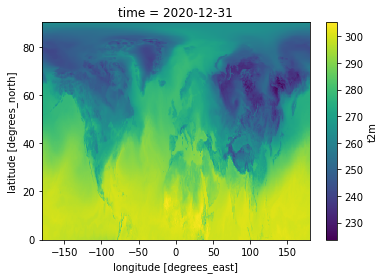

In [14]:
%%time
# plot the last timestep using the daily dataset generated using open_dataarray
da_daily.isel(time=-1).plot()

CPU times: user 330 ms, sys: 14.9 ms, total: 345 ms
Wall time: 1.64 s


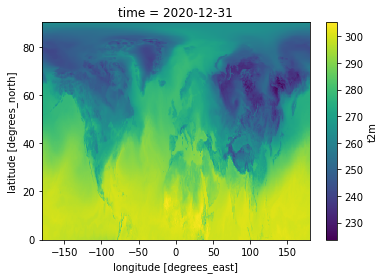

In [15]:
%%time
# plot the last timestep using the daily dataset generated using open_mfdataset
da_daily_mfdataset.isel(time=-1)['t2m'].plot()

CPU times: user 35 ms, sys: 3.91 ms, total: 38.9 ms
Wall time: 34.7 ms


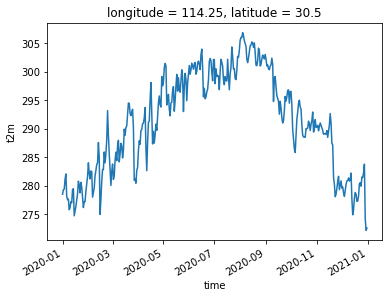

In [16]:
%%time
# plot a timeseries at one location using the daily dataset generated using open_dataarray
da_daily.sel(longitude=114.3055, latitude=30.5928, method='nearest').plot()

CPU times: user 3.56 s, sys: 771 ms, total: 4.33 s
Wall time: 48.8 s


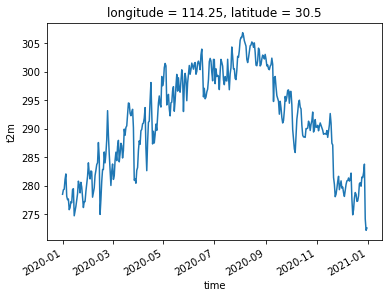

In [17]:
%%time
# plot a timeseries at one location using the daily dataset generated using open_dataarray
# notes1: slower than the daily dataset generated using open_mfdataset
# notes2: it doesn't work when using open_mfdataset and dask FALSE (memory issues)
da_daily_mfdataset.sel(longitude=114.3055, latitude=30.5928, method='nearest')['t2m'].plot()

## Close the Client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [18]:
client.close()